# Loading libraries and data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
df = pd.read_csv('/kaggle/input/churn-prediction-dataset/train.csv')

# Undertanding the data

In [3]:
df.shape

(243787, 21)

In [4]:
df.head()

,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,...,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID,Churn
0,20,11.055215,221.104302,Premium,Mailed check,No,Both,No,Mobile,36.758104,...,10,Sci-Fi,2.176498,4,Male,3,No,No,CB6SXPNVZA,0
1,57,5.175208,294.986882,Basic,Credit card,Yes,Movies,No,Tablet,32.450568,...,18,Action,3.478632,8,Male,23,No,Yes,S7R2G87O09,0
2,73,12.106657,883.785952,Basic,Mailed check,Yes,Movies,No,Computer,7.395160,...,23,Fantasy,4.238824,6,Male,1,Yes,Yes,EASDC20BDT,0
3,32,7.263743,232.439774,Basic,Electronic check,No,TV Shows,No,Tablet,27.960389,...,30,Drama,4.276013,2,Male,24,Yes,Yes,NPF69NT69N,0
4,57,16.953078,966.325422,Premium,Electronic check,Yes,TV Shows,No,TV,20.083397,...,20,Comedy,3.616170,4,Female,0,No,No,4LGYPK7VOL,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243787 entries, 0 to 243786
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   AccountAge                243787 non-null  int64  
 1   MonthlyCharges            243787 non-null  float64
 2   TotalCharges              243787 non-null  float64
 3   SubscriptionType          243787 non-null  object 
 4   PaymentMethod             243787 non-null  object 
 5   PaperlessBilling          243787 non-null  object 
 6   ContentType               243787 non-null  object 
 7   MultiDeviceAccess         243787 non-null  object 
 8   DeviceRegistered          243787 non-null  object 
 9   ViewingHoursPerWeek       243787 non-null  float64
 10  AverageViewingDuration    243787 non-null  float64
 11  ContentDownloadsPerMonth  243787 non-null  int64  
 12  GenrePreference           243787 non-null  object 
 13  UserRating                243787 non-null  f

# Data Manipulation

In [6]:
df = df.drop(columns=['CustomerID'])

In [7]:
df.isna().sum()

AccountAge                  0
MonthlyCharges              0
TotalCharges                0
SubscriptionType            0
PaymentMethod               0
PaperlessBilling            0
ContentType                 0
MultiDeviceAccess           0
DeviceRegistered            0
ViewingHoursPerWeek         0
AverageViewingDuration      0
ContentDownloadsPerMonth    0
GenrePreference             0
UserRating                  0
SupportTicketsPerMonth      0
Gender                      0
WatchlistSize               0
ParentalControl             0
SubtitlesEnabled            0
Churn                       0
dtype: int64

In [8]:
df.duplicated().sum()

0

# Data Visualization

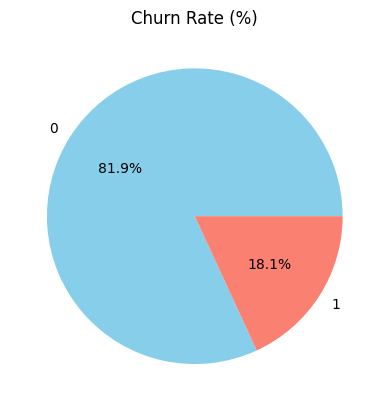

In [9]:
df['Churn'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue','salmon'])
plt.title('Churn Rate (%)')
plt.ylabel('')
plt.show()

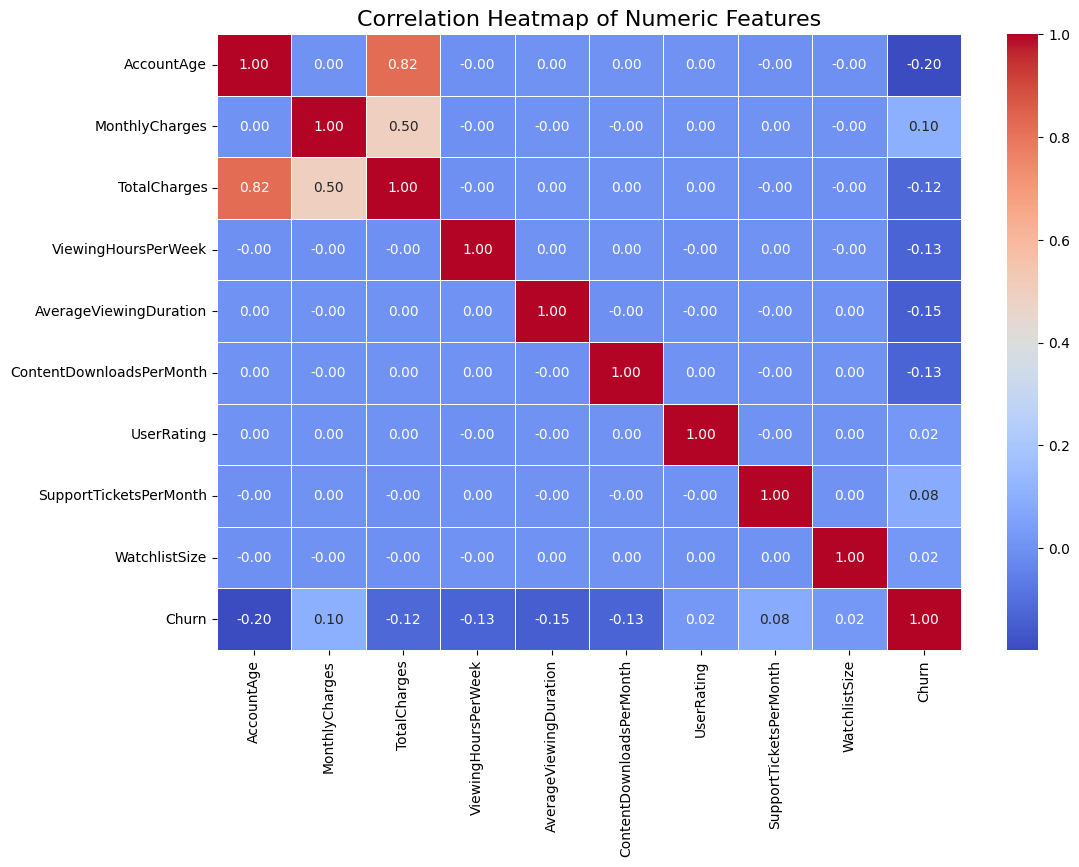

In [10]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Tính ma trận tương quan
corr = numeric_df.corr()

# Kích thước và style biểu đồ
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Heatmap of Numeric Features', fontsize=16)
plt.show()

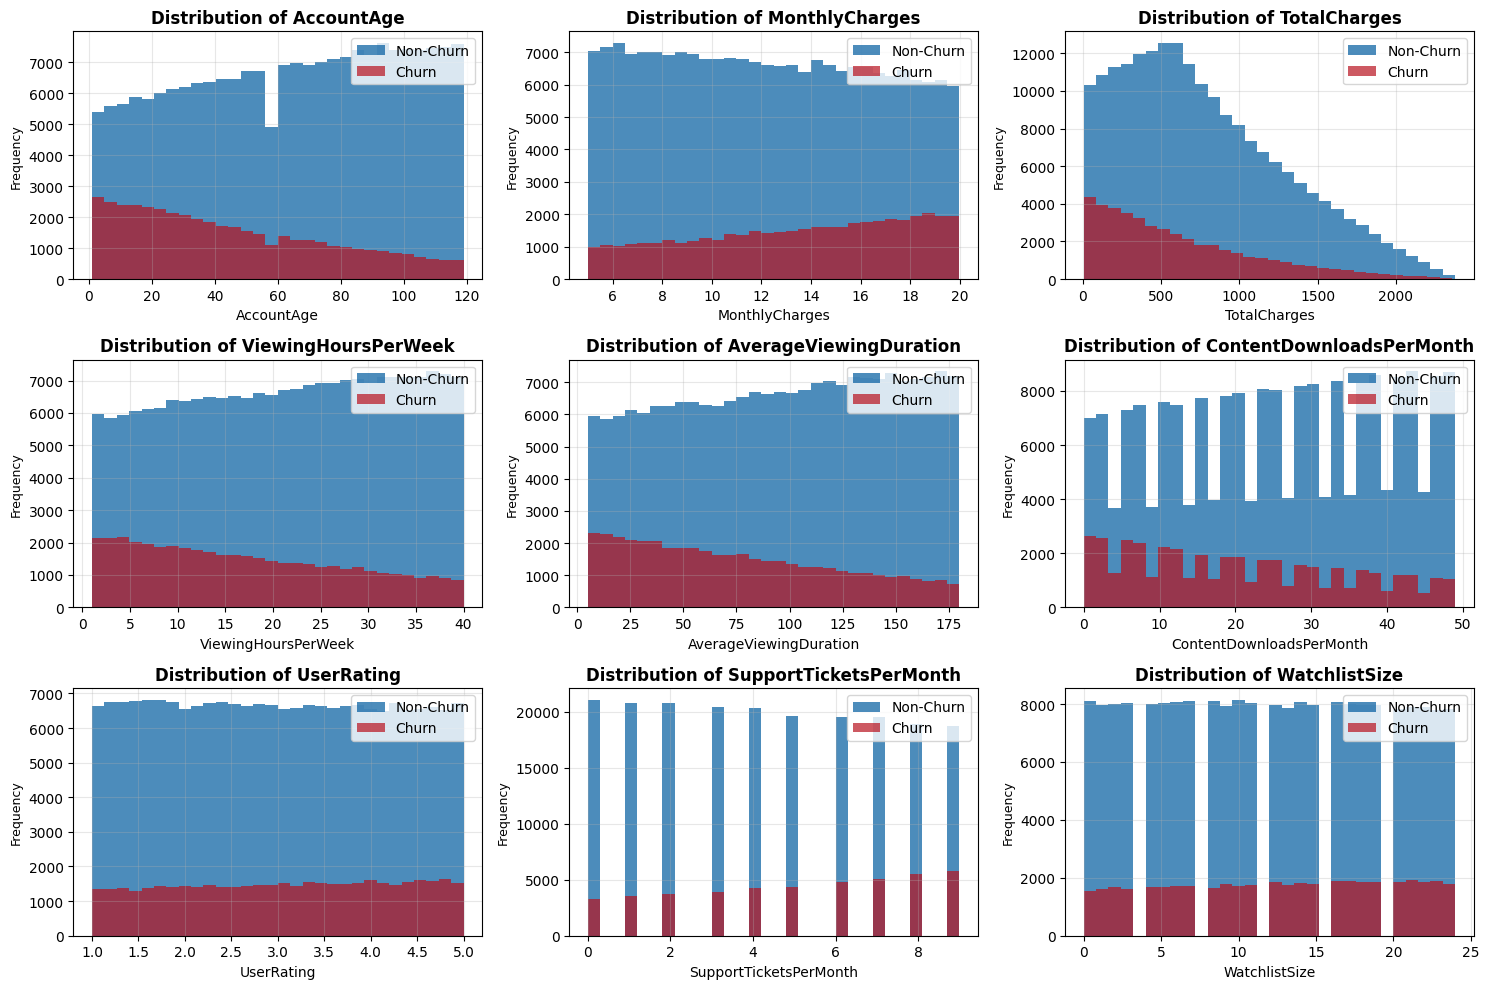

In [11]:
num_cols = ['AccountAge', 'MonthlyCharges', 'TotalCharges', 'ViewingHoursPerWeek',
                'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating',
                'SupportTicketsPerMonth', 'WatchlistSize']

non_churn = df[df['Churn'] == 0]
churn = df[df['Churn'] == 1]

num_plots = len(num_cols)
n_cols = 3
n_rows = (num_plots + n_cols - 1) // n_cols  # tính số hàng cần thiết

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

COLOR_NON_CHURN = '#005b9f'  # Dark Blue
COLOR_CHURN = '#b8121f'      # Deep Red

for i, col in enumerate(num_cols):
    ax = axes[i]

    # Histogram for Non-Churn
    non_churn[col].hist(
        ax=ax, bins=30, alpha=0.7,
        label='Non-Churn', color=COLOR_NON_CHURN
    )

    # Histogram for Churn
    churn[col].hist(
        ax=ax, bins=30, alpha=0.7,
        label='Churn', color=COLOR_CHURN
    )

    # Formatting
    ax.set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=9)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
plt.style.use('default')


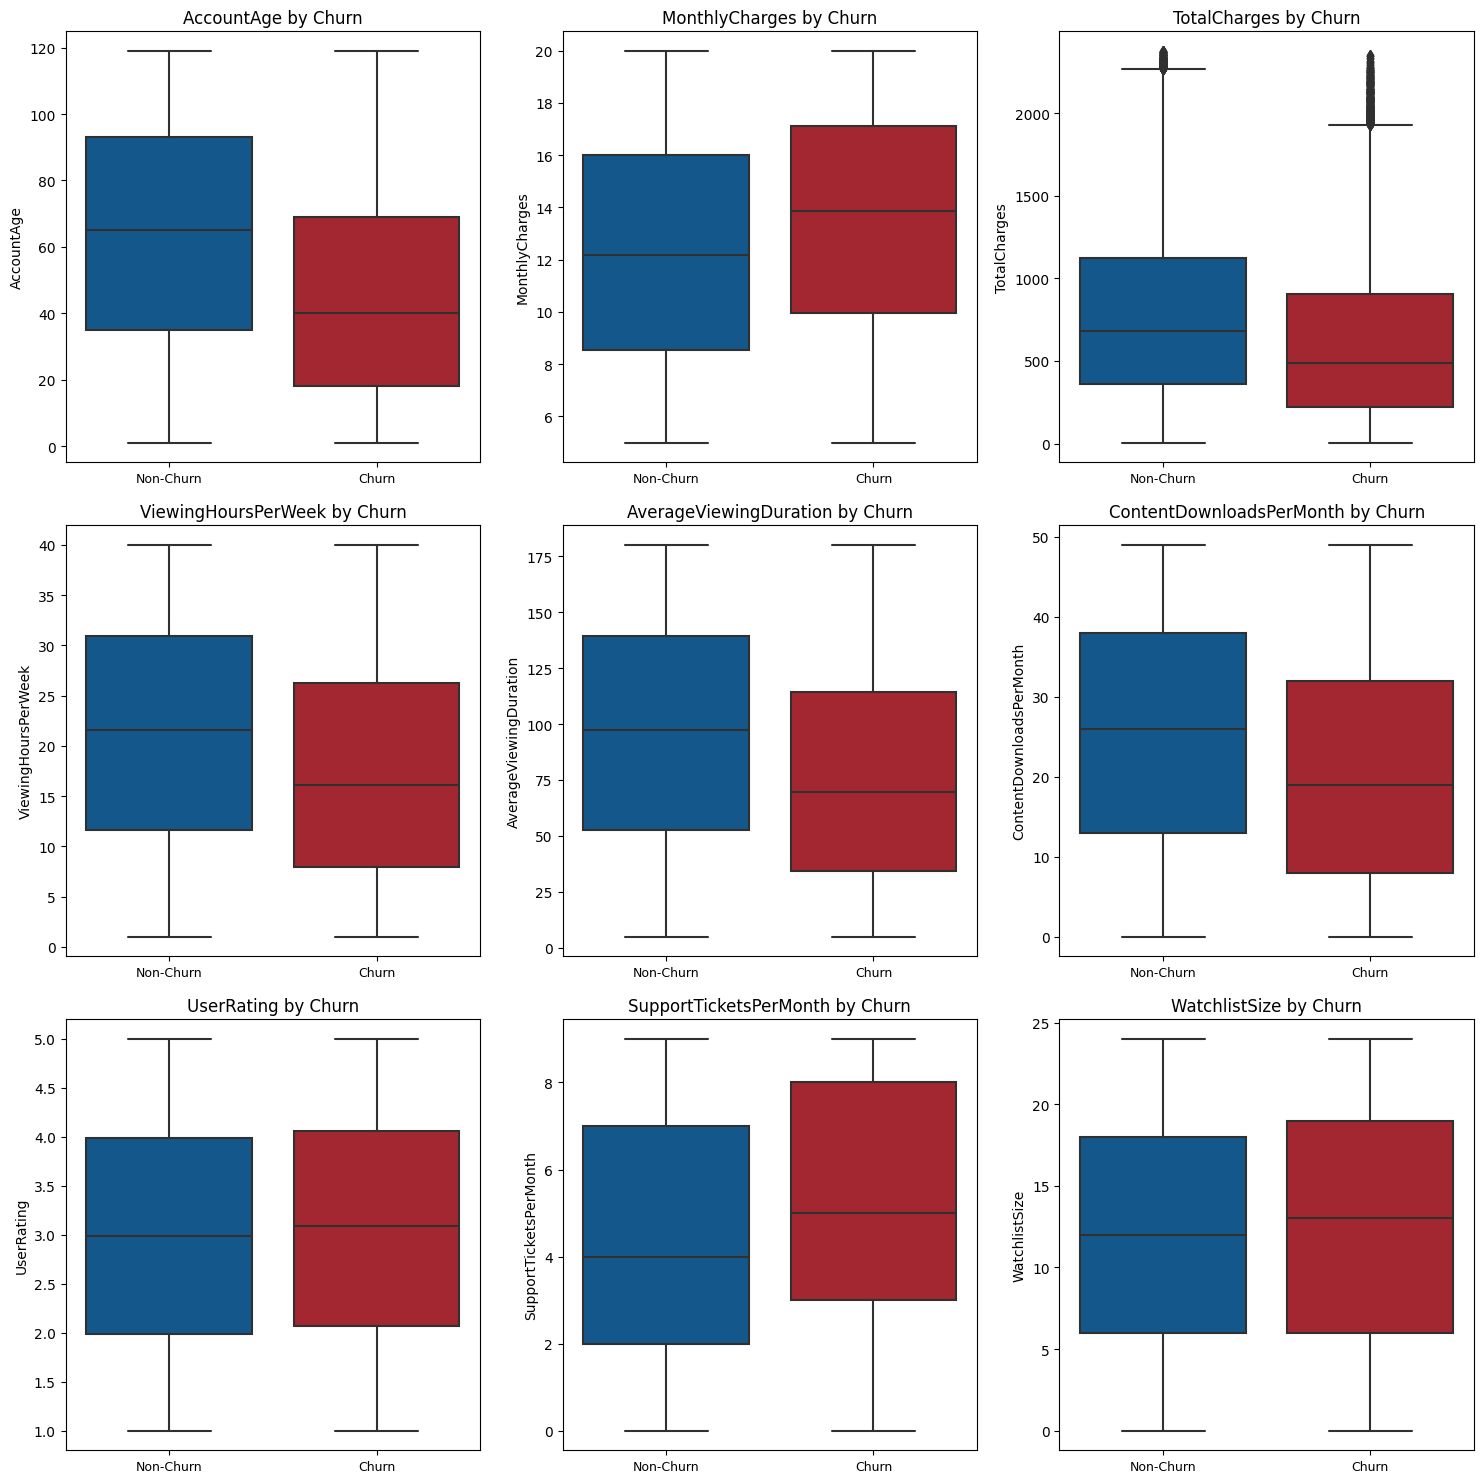

In [12]:
num_features = [
    'AccountAge', 'MonthlyCharges', 'TotalCharges', 'ViewingHoursPerWeek',
    'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating',
    'SupportTicketsPerMonth', 'WatchlistSize'
]

# --- Step 2: Determine subplot grid layout ---
total = len(num_features)
cols = 3
rows = -(-total // cols)  # tương đương math.ceil(total / cols)

fig, ax_arr = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
ax_arr = ax_arr.ravel()  # flatten thành 1 chiều

# Optional: Set seaborn theme for cleaner visuals
sns.set_theme(style="whitegrid")

for idx, feature in enumerate(num_features):
    ax = ax_arr[idx]
    sns.boxplot(
        data=df,
        x='Churn',
        y=feature,
        ax=ax,
        palette=['#005b9f', '#b8121f']
    )
    ax.set_title(f'{feature} by Churn', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel(feature, fontsize=10)
    
    ax.set_xticklabels(['Non-Churn', 'Churn'], fontsize=9)

for empty in range(total, rows * cols):
    fig.delaxes(ax_arr[empty])

plt.tight_layout()
plt.show()


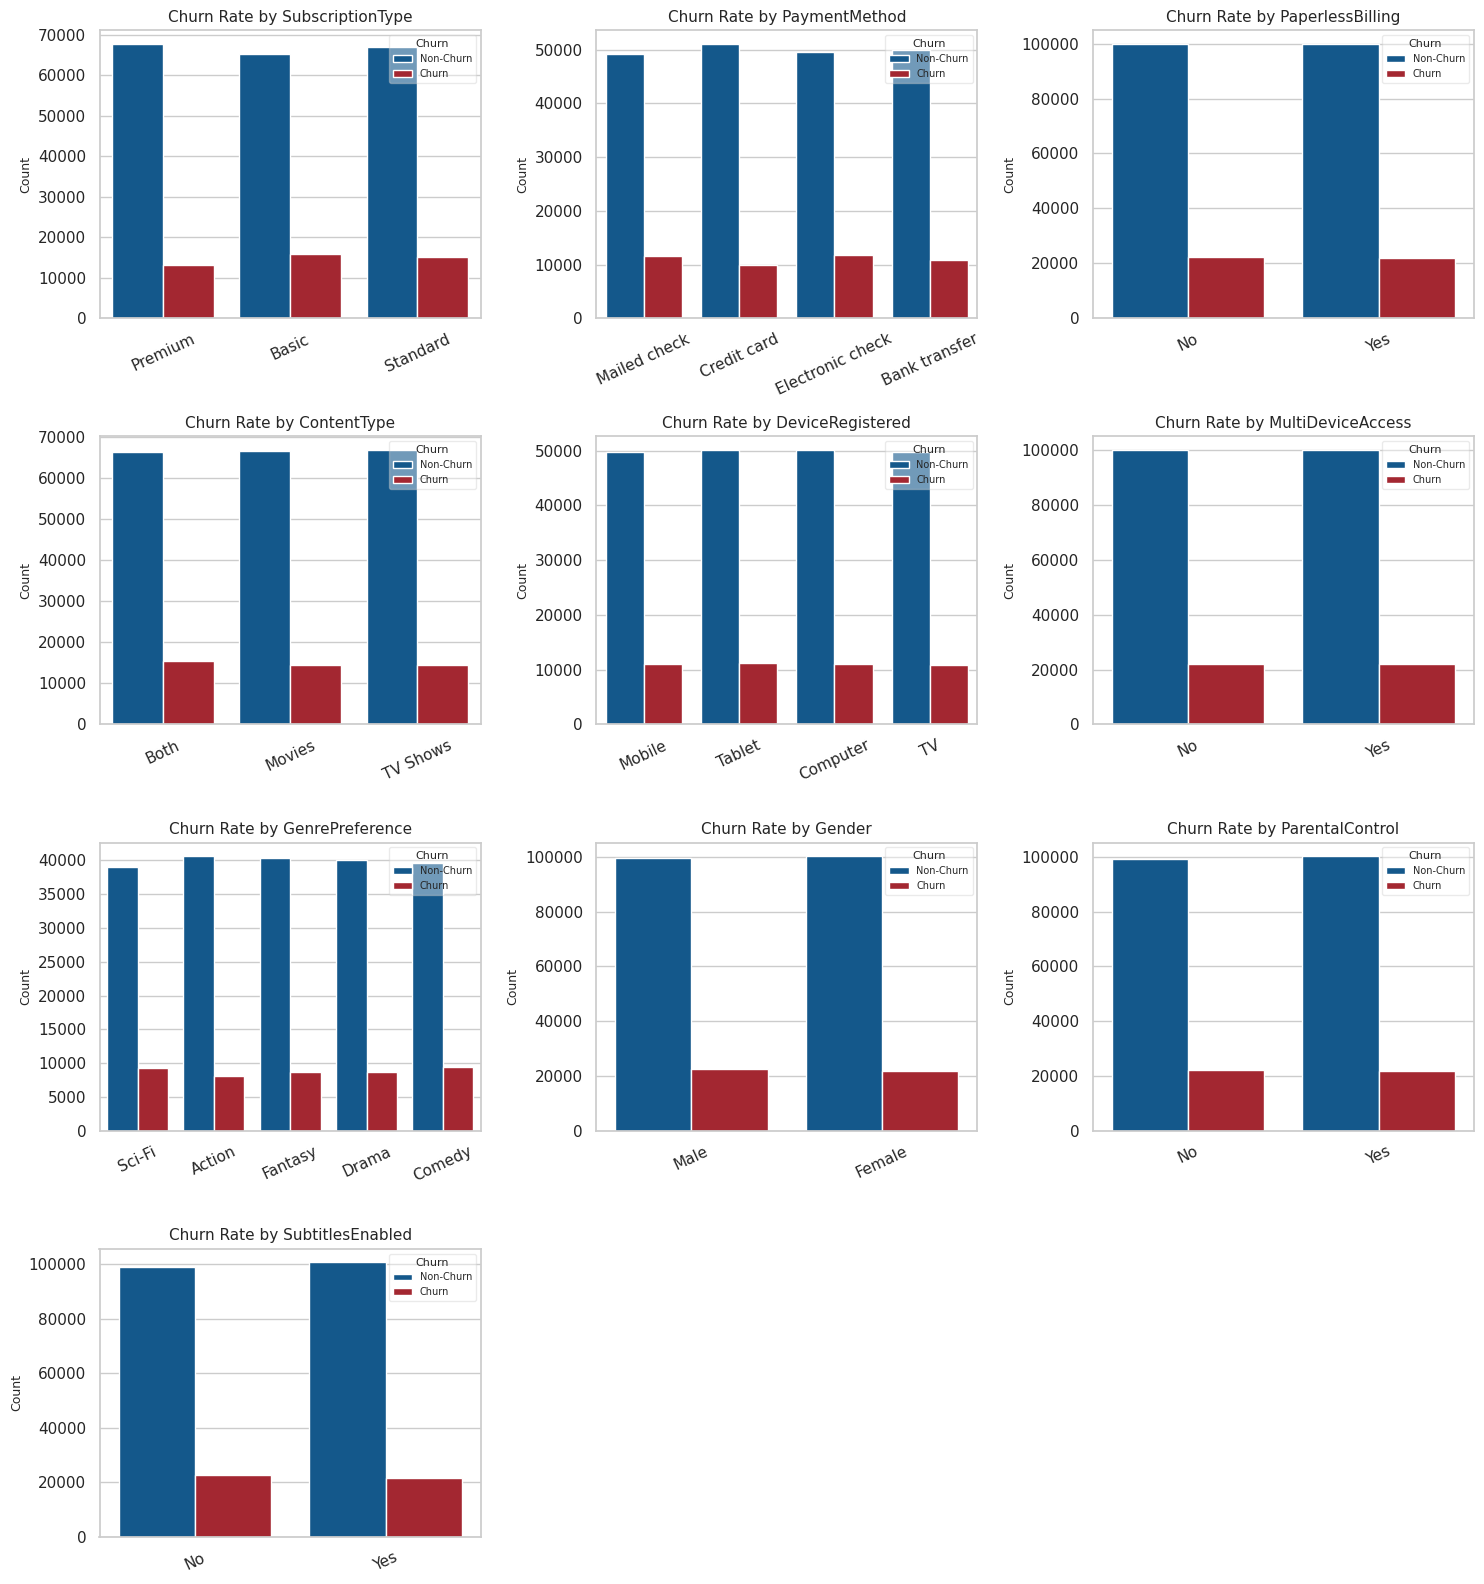

In [13]:

# --- 1. Danh sách các biến phân loại ---
cat_cols = [
    'SubscriptionType', 'PaymentMethod', 'PaperlessBilling', 'ContentType',
    'DeviceRegistered', 'MultiDeviceAccess', 'GenrePreference', 'Gender',
    'ParentalControl', 'SubtitlesEnabled'
]

# --- 2. Thiết lập bố cục subplot ---
total = len(cat_cols)
cols = 3
rows = -(-total // cols)  # tương đương math.ceil(total / cols)

fig, ax_arr = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
ax_arr = ax_arr.flatten()

# --- 3. Set seaborn style ---
sns.set_theme(style="whitegrid")

# --- 4. Vẽ countplot ---
for idx, feature in enumerate(cat_cols):
    ax = ax_arr[idx]
    sns.countplot(
        data=df,
        x=feature,
        hue='Churn',
        ax=ax,
        palette=['#005b9f', '#b8121f']
    )
    ax.set_title(f'Churn Rate by {feature}', fontsize=11)
    ax.set_xlabel('')
    ax.set_ylabel('Count', fontsize=9)
    ax.tick_params(axis='x', rotation=25)
    legend = ax.legend(
        title='Churn',
        labels=['Non-Churn', 'Churn'],
        loc='upper right',
        frameon=True,
        fontsize=7,
        title_fontsize=8,
        framealpha=0.4  # làm mờ legend
    )

# --- 5. Ẩn subplot trống nếu có ---
for empty in range(total, rows * cols):
    fig.delaxes(ax_arr[empty])

# --- 6. Hiển thị bố cục gọn gàng ---
plt.tight_layout()
plt.show()


# Data Preprocessing

In [14]:
# 1. Xử lý missing
df = df.dropna()

# 2. Encode Yes/No
binary_cols = ['PaperlessBilling', 'MultiDeviceAccess', 'ParentalControl', 'SubtitlesEnabled']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# 3. One-hot encoding
categorical_cols = ['SubscriptionType', 'PaymentMethod', 'ContentType', 'DeviceRegistered', 'GenrePreference', 'Gender']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True).astype(int)

# 4. Chuẩn hóa numeric
numeric_cols = ['AccountAge', 'MonthlyCharges', 'TotalCharges', 'ViewingHoursPerWeek',
                'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating',
                'SupportTicketsPerMonth', 'WatchlistSize']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [15]:
target_col = 'Churn'

# Chia dữ liệu X, y
X = df.drop(columns=[target_col])
y = df[target_col]

# Chia train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Machine Learning Model Evaluations and Predictions

In [16]:
ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=1000,           # Tăng để có thêm cây, nhưng sẽ dừng sớm nhờ early stopping
    learning_rate=0.02,          # Học chậm hơn để mô hình tổng quát tốt hơn
    max_depth=4,                 # Giảm depth tránh overfit
    subsample=0.8,               # Giữ lại 80% data mỗi cây
    colsample_bytree=0.8,        # Giữ lại 80% feature mỗi cây
    gamma=1,                     # Thêm regularization, giảm overfit
    min_child_weight=3,          # Giới hạn số lượng mẫu trong node lá
    scale_pos_weight=ratio,      # Cân bằng dữ liệu (sẽ tính bên dưới)
    reg_lambda=1,                # L2 regularization
    reg_alpha=0,                 # L1 regularization (tăng nếu có nhiều feature rác)
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [17]:
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]  # xác suất thuộc lớp churn

print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred))

roc = roc_auc_score(y_test, y_prob)
print(f"🔹 ROC-AUC Score: {roc:.4f}")


🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.67      0.77     39921
           1       0.32      0.70      0.44      8837

    accuracy                           0.68     48758
   macro avg       0.62      0.69      0.61     48758
weighted avg       0.80      0.68      0.71     48758

🔹 ROC-AUC Score: 0.7529


<Figure size 1000x600 with 0 Axes>

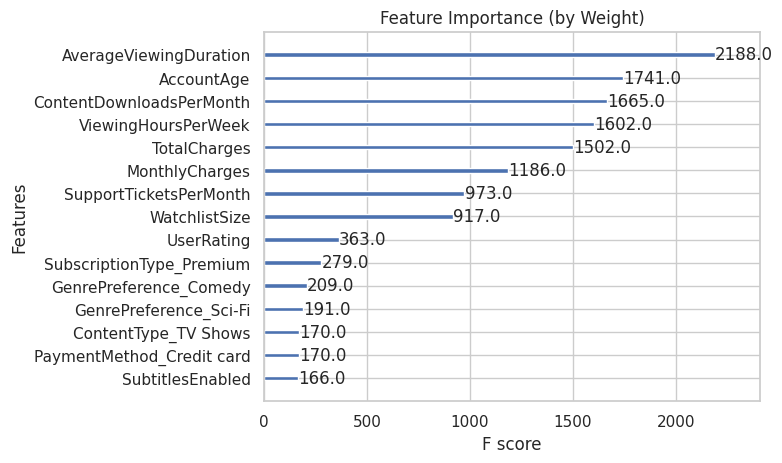

In [18]:
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=15, importance_type='weight')
plt.title("Feature Importance (by Weight)")
plt.show()

### Explanable Feature

In [19]:
# import shap

# explainer = shap.Explainer(xgb_model, X_train)
# shap_values = explainer(X_test)

In [20]:
# Tổng quan tất cả feature
# shap.summary_plot(shap_values, X_test, plot_type="bar")

In [21]:
# shap.summary_plot(shap_values, X_test, plot_type="dot")